# 02-2 고급 CNN 모델과 전이 학습

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/hm-dl/blob/main/02-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

## DenseNet

In [1]:
import keras
from keras import layers

In [2]:
def dense_block(x, blocks):
    for _ in range(blocks):
        x1 = layers.BatchNormalization(epsilon=1e-5)(x)
        x1 = layers.Activation('relu')(x1)
        x1 = layers.Conv2D(128, 1, use_bias=False)(x1)
        x1 = layers.BatchNormalization(epsilon=1e-5)(x1)
        x1 = layers.Activation('relu')(x1)
        x1 = layers.Conv2D(32, 3, padding='same', use_bias=False)(x1)
        x = layers.Concatenate()([x, x1])
    return x

In [3]:
def transition_block(x):
    x = layers.BatchNormalization(epsilon=1e-5)(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(int(x.shape[-1]/2), 1, use_bias=False)(x)
    x = layers.AveragePooling2D(2)(x)
    return x

In [5]:
inputs = layers.Input(shape=(224, 224, 3))

x = layers.ZeroPadding2D(padding=3)(inputs)
x = layers.Conv2D(64, 7, strides=2, use_bias=False)(x)
x = layers.BatchNormalization(epsilon=1e-5)(x)
x = layers.Activation('relu')(x)
x = layers.ZeroPadding2D(padding=1)(x)
x = layers.MaxPooling2D(3, strides=2)(x)

for blocks in (6, 12, 24):
    x = dense_block(x, blocks)
    x = transition_block(x)
x = dense_block(x, 16)

x = layers.BatchNormalization(epsilon=1e-5)(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1000, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [6]:
# 코랩의 경우 구글 드라이브에서 샘플 이미지를 다운로드하여 압축을 풉니다.
!gdown 1xGkTT3uwYt4myj6eJJeYtdEFgTi2Sj8C
!unzip cat-dog-images.zip

Downloading...
From: https://drive.google.com/uc?id=1xGkTT3uwYt4myj6eJJeYtdEFgTi2Sj8C
To: /content/cat-dog-images.zip
100% 182k/182k [00:00<00:00, 117MB/s]
Archive:  cat-dog-images.zip
   creating: images/
  inflating: images/dog.png          
  inflating: images/cat.png          


In [7]:
import numpy as np
from PIL import Image

dog_png = np.array(Image.open('images/dog.png'))

In [8]:
from keras.applications import densenet

dense_prep_dog = densenet.preprocess_input(dog_png)

In [9]:
densenet201 = keras.applications.DenseNet201()
predictions = densenet201.predict(dense_prep_dog[np.newaxis,:])
densenet.decode_predictions(predictions)

35363/35363 [==============================] - 0s 1us/step


[[('n02099712', 'Labrador_retriever', 0.52812),
  ('n04409515', 'tennis_ball', 0.19857815),
  ('n02104029', 'kuvasz', 0.060605355),
  ('n02111500', 'Great_Pyrenees', 0.027188243),
  ('n02099601', 'golden_retriever', 0.017613882)]]

## MobileNet

In [10]:
def depthwise_separable_block(inputs, filters, strides=1):
    if strides == 1:
        x = inputs
    else:
        x = layers.ZeroPadding2D(padding=((0, 1), (0, 1)))(inputs)

    x = layers.DepthwiseConv2D(3, padding='same' if strides == 1 else 'valid',
                               strides=strides, use_bias=False)(x)
    x = layers.BatchNormalization(epsilon=1e-5)(x)
    x = layers.ReLU(max_value=6.0)(x)
    x = layers.Conv2D(filters, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization(epsilon=1e-5)(x)
    x = layers.ReLU(max_value=6.0)(x)
    return x

In [11]:
inputs = layers.Input(shape=(224, 224, 3))

x = layers.Conv2D(32, 3, padding='same', strides=2, use_bias=False)(inputs)
x = layers.BatchNormalization(epsilon=1e-5)(x)
x = layers.ReLU(max_value=6.0)(x)

for filters in (64, 128, 256):
    x = depthwise_separable_block(x, filters)
    x = depthwise_separable_block(x, filters*2, strides=2)
for _ in range(5):
    x = depthwise_separable_block(x, 512)
x = depthwise_separable_block(x, 1024, strides=2)
x = depthwise_separable_block(x, 1024)

x = layers.GlobalAveragePooling2D(keepdims=True)(x)
x = layers.Dropout(0.001)(x)
x = layers.Conv2D(1000, 1, padding='same')(x)
x = layers.Reshape((1000,))(x)
outputs = layers.Activation('softmax')(x)

model = keras.Model(inputs, outputs)

In [12]:
from keras.applications import mobilenet

mobile_prep_dog = mobilenet.preprocess_input(dog_png)
model = keras.applications.MobileNet()
predictions = model.predict(mobile_prep_dog[np.newaxis,:])
mobilenet.decode_predictions(predictions)

1/1 [==============================] - 1s 1s/step


[[('n02099712', 'Labrador_retriever', 0.40903673),
  ('n02104029', 'kuvasz', 0.18954755),
  ('n02110341', 'dalmatian', 0.14881718),
  ('n02111500', 'Great_Pyrenees', 0.042762745),
  ('n02099601', 'golden_retriever', 0.027608255)]]

## EfficientNet

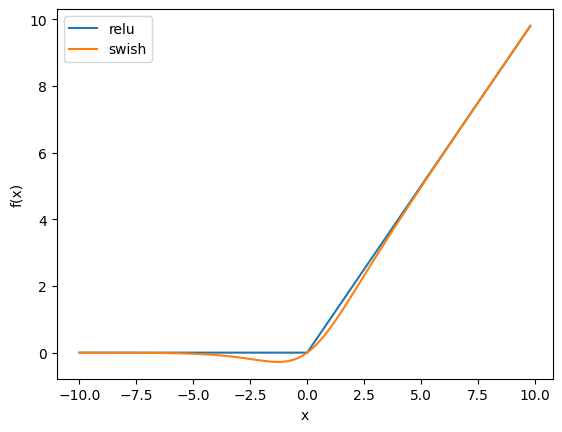

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

x = np.arange(-10, 10, 0.2)

plt.plot(x, x.clip(0), label='relu')
plt.plot(x, x * expit(x), label='swish')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

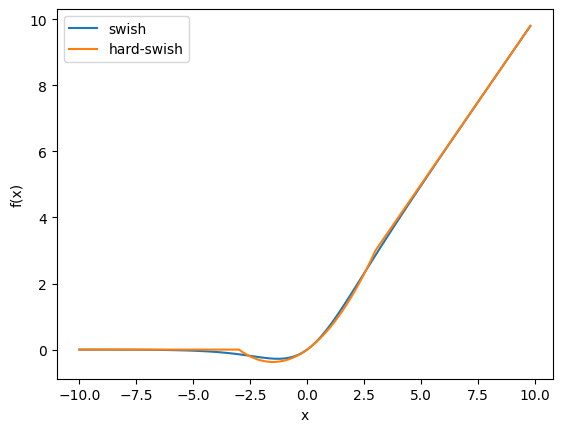

In [14]:
def relu6(x):
    return np.minimum(np.maximum(x, 0), 6)

x = np.arange(-10, 10, 0.2)

plt.plot(x, x * expit(x), label='swish')
plt.plot(x, x * relu6(x+3)/6, label='hard-swish')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

In [15]:
def inv_res_block(inputs, filters_out, kernel_size, strides, dropout_rate, expand_ratio):
    # 팽창 단계
    filters_in = inputs.shape[-1]
    filters = filters_in * expand_ratio
    if expand_ratio > 1:
        x = layers.Conv2D(filters, 1, padding='same', use_bias=False)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('swish')(x)
    else:
        x = inputs

    # 깊이별 분리 합성곱
    if strides == 2:
        x = layers.ZeroPadding2D(padding=padding_size(x.shape, kernel_size))(x)
    x = layers.DepthwiseConv2D(kernel_size, strides=strides, use_bias=False,
                               padding='same' if strides == 1 else 'valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)

    # SE 블록
    se_input = x
    x = layers.GlobalAveragePooling2D(keepdims=True)(x)
    x = layers.Conv2D(filters_in * 0.25, 1, padding='same', activation='swish')(x)
    x = layers.Conv2D(filters, 1, padding='same', activation='sigmoid')(x)
    x = layers.Multiply()([se_input, x])

    # 출력 단계
    x = layers.Conv2D(filters_out, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    if strides == 1 and filters_in == filters_out:
        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate, noise_shape=(None, 1, 1, 1))(x)
            x = layers.Add()([x, inputs])
    return x

In [16]:
def padding_size(input_size, kernel_size):
    # 입력 크기가 짝수이면 아래쪽과 오른쪽만 패딩합니다.
    padding = kernel_size // 2
    if input_size[1] % 2 == 0:
        return ((padding - 1, padding),
                (padding - 1, padding))
    else:
        return padding

In [17]:
import math

def round_repeats(repeats, depth):
    """repeats * depth 보다 큰 정수를 반환합니다"""
    return int(math.ceil(repeats * depth))

def round_filters(filters, width):
    """filters * width 보다 크고 8의 배수가 되도록 만듭니다"""
    filters *= width
    new_filters = max(8, int(filters + 4) // 8 * 8)
    if new_filters < 0.9 * filters:
        new_filters += 8
    return int(new_filters)

In [18]:
width = 1.0
depth = 1.0
inputs = layers.Input(shape=(224, 224, 3))

x = layers.Rescaling(1.0 / 255.0)(inputs)
x = layers.Normalization()(x)
x = layers.Rescaling(1.0 / np.sqrt([0.229, 0.224, 0.225]))(x)
x = layers.ZeroPadding2D(padding=padding_size(x.shape, 3))(x)
x = layers.Conv2D(round_filters(32, width), 3, strides=2, padding='valid', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('swish')(x)

In [19]:
blocks_params = [
    {
        "kernel_size": 3,
        "repeats": 1,
        "filters_out": 16,
        "strides": 1
    },
    {
        "kernel_size": 3,
        "repeats": 2,
        "filters_out": 24,
        "strides": 2
    },
    {
        "kernel_size": 5,
        "repeats": 2,
        "filters_out": 40,
        "strides": 2
    },
    {
        "kernel_size": 3,
        "repeats": 3,
        "filters_out": 80,
        "strides": 2
    },
    {
        "kernel_size": 5,
        "repeats": 3,
        "filters_out": 112,
        "strides": 1
    },
    {
        "kernel_size": 5,
        "repeats": 4,
        "filters_out": 192,
        "strides": 2
    },
    {
        "kernel_size": 3,
        "repeats": 1,
        "filters_out": 320,
        "strides": 1
    },
]

In [20]:
filter_expand_ratio = 1
block_count = 0
total_blocks = float(sum(round_repeats(params["repeats"], depth) for params in blocks_params))
for params in blocks_params:
    # depth에 따라 블록의 입력과 출력 필터를 늘립니다.
    filters_out = round_filters(params['filters_out'], width)
    strides = params["strides"]
    for j in range(round_repeats(params["repeats"], depth)):
        # 반복의 첫 번째 블록을 제외한 나머지 블록은 스트라이드 1입니다.
        if j > 0:
            strides = 1
        dropout_rate = 0.2 * block_count / total_blocks
        x = inv_res_block(x, filters_out, params['kernel_size'],
                          strides, dropout_rate, filter_expand_ratio)
        block_count += 1
    filter_expand_ratio = 6

In [21]:
x = layers.Conv2D(round_filters(1280, width), 1, padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('swish')(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1000, activation='softmax')(x)

model = keras.Model(inputs, outputs)

In [22]:
from keras.applications import efficientnet

efficientb0 = keras.applications.EfficientNetB0()
predictions = efficientb0.predict(dog_png[np.newaxis,:])
efficientnet.decode_predictions(predictions)

1/1 [==============================] - 3s 3s/step


[[('n02099712', 'Labrador_retriever', 0.368294),
  ('n02104029', 'kuvasz', 0.19339865),
  ('n02099601', 'golden_retriever', 0.061458245),
  ('n02111500', 'Great_Pyrenees', 0.057797015),
  ('n02095889', 'Sealyham_terrier', 0.017902777)]]

## 모델 저장소 사용하기

In [23]:
import tensorflow as tf
import tensorflow_hub as hub

hub_efficientb0 = tf.keras.Sequential([
    layers.Rescaling(1.0 / 255.0, input_shape=(224, 224, 3)),
    hub.KerasLayer("https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b0-classification/versions/1")
])

predictions = hub_efficientb0.predict(dog_png[np.newaxis,:])
efficientnet.decode_predictions(predictions)

1/1 [==============================] - 1s 845ms/step


[[('n02099712', 'Labrador_retriever', 0.3682942),
  ('n02104029', 'kuvasz', 0.19339868),
  ('n02099601', 'golden_retriever', 0.061458193),
  ('n02111500', 'Great_Pyrenees', 0.05779694),
  ('n02095889', 'Sealyham_terrier', 0.017902788)]]

In [24]:
from transformers import pipeline

pipe = pipeline(task='image-classification', model='google/efficientnet-b0')
pipe('images/dog.png')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/70.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

[{'label': 'Labrador retriever', 'score': 0.368294358253479},
 {'label': 'kuvasz', 'score': 0.19339904189109802},
 {'label': 'golden retriever', 'score': 0.061458274722099304},
 {'label': 'Great Pyrenees', 'score': 0.057796820998191833},
 {'label': 'Sealyham terrier, Sealyham', 'score': 0.017902739346027374}]

## 전이 학습

In [25]:
!gdown 10bnEC6-ZfXZFZ2mb3zoWd38TjYufanWo

Downloading...
From: https://drive.google.com/uc?id=10bnEC6-ZfXZFZ2mb3zoWd38TjYufanWo
To: /content/Pistachio_Image_Dataset.zip
100% 25.9M/25.9M [00:00<00:00, 52.2MB/s]


In [26]:
!unzip -q Pistachio_Image_Dataset.zip

In [27]:
pistachio_sample = np.array(Image.open('Pistachio_Image_Dataset/Kirmizi_Pistachio/kirmizi (1).jpg'))

In [28]:
pistachio_sample.shape

(600, 600, 3)

In [29]:
efficientb7 = keras.applications.EfficientNetB7()

predictions = efficientb7.predict(pistachio_sample[np.newaxis,:])
efficientnet.decode_predictions(predictions)

268326632/268326632 [==============================] - 15s 0us/step


1/1 [==============================] - 8s 8s/step


[[('n01950731', 'sea_slug', 0.23482406),
  ('n01924916', 'flatworm', 0.20674424),
  ('n01943899', 'conch', 0.086223446),
  ('n01945685', 'slug', 0.08500548),
  ('n01955084', 'chiton', 0.028242918)]]

In [30]:
keras_efficientb0_base = keras.applications.EfficientNetB0(include_top=False)
feature_map = keras_efficientb0_base(pistachio_sample[np.newaxis,:])
feature_map.shape

16705208/16705208 [==============================] - 2s 0us/step


TensorShape([1, 18, 18, 1280])

In [31]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    'Pistachio_Image_Dataset', image_size=(224, 224), batch_size=16,
    validation_split=0.2, subset='both', seed=42
)

Found 2148 files belonging to 2 classes.
Using 1719 files for training.
Using 429 files for validation.


In [32]:
keras_efficientb0_base.trainable = False

inputs = keras.Input(shape=(224, 224, 3))
x = keras_efficientb0_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

rmsprop = keras.optimizers.RMSprop(learning_rate=5e-5)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
108/108 [==============================] - 29s 91ms/step - loss: 0.4931 - accuracy: 0.8005 - val_loss: 0.3528 - val_accuracy: 0.9184
Epoch 2/20
108/108 [==============================] - 5s 43ms/step - loss: 0.3164 - accuracy: 0.9133 - val_loss: 0.2431 - val_accuracy: 0.9394
Epoch 3/20
108/108 [==============================] - 5s 47ms/step - loss: 0.2343 - accuracy: 0.9331 - val_loss: 0.1890 - val_accuracy: 0.9441
Epoch 4/20
108/108 [==============================] - 5s 46ms/step - loss: 0.1837 - accuracy: 0.9459 - val_loss: 0.1585 - val_accuracy: 0.9510
Epoch 5/20
108/108 [==============================] - 5s 46ms/step - loss: 0.1524 - accuracy: 0.9552 - val_loss: 0.1371 - val_accuracy: 0.9650
Epoch 6/20
108/108 [==============================] - 5s 43ms/step - loss: 0.1385 - accuracy: 0.9604 - val_loss: 0.1231 - val_accuracy: 0.9674
Epoch 7/20
108/108 [==============================] - 6s 51ms/step - loss: 0.1200 - accuracy: 0.9674 - val_loss: 0.1141 - val_accuracy: 0.969

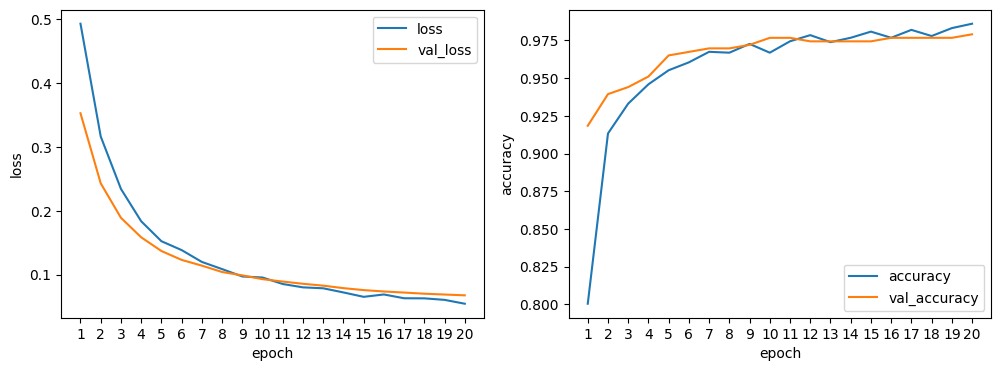

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(range(1, 21), hist.history['loss'], label='loss')
axs[0].plot(range(1, 21), hist.history['val_loss'], label='val_loss')
axs[0].set_xticks(range(1, 21))
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].legend()
axs[1].plot(range(1, 21), hist.history['accuracy'], label='accuracy')
axs[1].plot(range(1, 21), hist.history['val_accuracy'], label='val_accuracy')
axs[1].set_xticks(range(1, 21))
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')
axs[1].legend()
plt.show()

## 심화 학습

In [34]:
kaggle_efficientb0_base = hub.KerasLayer('https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b0-feature-vector/versions/1')

inputs = keras.Input(shape=(224, 224, 3))
x = layers.Rescaling(1.0 / 255.0)(inputs)
x = kaggle_efficientb0_base(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
108/108 [==============================] - 17s 74ms/step - loss: 0.4052 - accuracy: 0.8499 - val_loss: 0.2592 - val_accuracy: 0.9324
Epoch 2/20
108/108 [==============================] - 5s 45ms/step - loss: 0.2070 - accuracy: 0.9407 - val_loss: 0.1658 - val_accuracy: 0.9487
Epoch 3/20
108/108 [==============================] - 5s 44ms/step - loss: 0.1429 - accuracy: 0.9616 - val_loss: 0.1323 - val_accuracy: 0.9557
Epoch 4/20
108/108 [==============================] - 5s 41ms/step - loss: 0.1115 - accuracy: 0.9709 - val_loss: 0.1240 - val_accuracy: 0.9604
Epoch 5/20
107/108 [============================>.] - ETA: 0s - loss: 0.0920 - accuracy: 0.9702

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(range(1, 21), hist.history['loss'], label='loss')
axs[0].plot(range(1, 21), hist.history['val_loss'], label='val_loss')
axs[0].set_xticks(range(1, 21))
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].legend()
axs[1].plot(range(1, 21), hist.history['accuracy'], label='accuracy')
axs[1].plot(range(1, 21), hist.history['val_accuracy'], label='val_accuracy')
axs[1].set_xticks(range(1, 21))
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')
axs[1].legend()
plt.show()